In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from stabl.preprocessing import LowInfoFilter
from stabl.stabl import Stabl, save_stabl_results,plot_stabl_path, plot_fdr_graph
from stabl.visualization import boxplot_features
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import LeaveOneOut,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score


This here provides the code that gets us the result of the best model on the V3 only unstim data. 

The best model found was a Lasso model, with hyperparameters \lambda_1 = 2. Reminder, the Lasso solves:
$$ \text{argmin}_\beta \frac{1}{2n} \| y - X\beta \|^2_2 + \lambda_1 \|\beta\|_1 $$

We also use the usual preprocessing pipeline, with a variance threshold of 0.075 (i.e. features with lower variance are removed before fitting the model).

### Step 1: Setup

We import the data and set up the preprocessing pipeline:

In [2]:
dataV3 = pd.read_csv("./Data/Alkahest-unprocessed-V3.csv",index_col=0)
dataV3 = dataV3.iloc[:,[x[-6:]  == "Unstim" for x in dataV3.columns]]
label = pd.read_csv("./Data/AlkahestLabel.csv",index_col=0).iloc[:,0]

preprocessing = Pipeline(
        steps=[
            ("variance", VarianceThreshold(0.0075)),
            ("lif", LowInfoFilter(0)),
            ("impute", SimpleImputer(strategy="median")),
            ("std", StandardScaler())
        ]
    )

X = dataV3.to_numpy()
y = label.to_numpy()

### Step 2: Cross-Validation

ow we calculate the ROC curve for the cross-validation predictions, using Leave-One-Out cross-validation. We obtain an AUC of 0.72 for the curve.

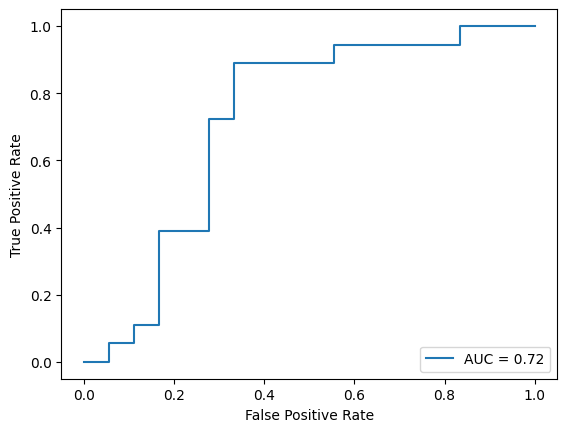

In [3]:
from sklearn.metrics import roc_curve,RocCurveDisplay,auc

c =  2
model = LogisticRegression(penalty="l1", C=c, max_iter=int(1e6), solver="saga", class_weight="balanced")
kf = LeaveOneOut()
all_probs=[]
for train, test in kf.split(X, y):
    Xtrain = pd.DataFrame(data=preprocessing.fit_transform(dataV3.iloc[train,:]),
                          index=dataV3.index[train],
                          columns=preprocessing.get_feature_names_out()
                         ).to_numpy()
    Xtest = pd.DataFrame(data=preprocessing.transform(dataV3.iloc[test,:]),
                          index=dataV3.index[test],
                          columns=preprocessing.get_feature_names_out()
                         ).to_numpy()
    all_probs.append(model.fit(Xtrain, y[train]).predict_proba(Xtest)[:,1])
all_probs = np.array(all_probs).flatten()
fpr, tpr, thresholds = roc_curve(y, all_probs)
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

We then calculate the p-value of the same predictions, which is about 2.4%.

In [4]:
from scipy.stats import mannwhitneyu

utest1,upval1 = mannwhitneyu(all_probs[y == 1],all_probs[y == 0],method="exact")
print( "p-value of the U-Test on the CV predictions : ",upval1)

p-value of the U-Test on the CV predictions :  0.024401295041849128


The spread of the predictions is in the next figure - 0 is placebo, 1 is Alkahest. The dots are the prediction values. Ideally we want the top line to have all dots at 0, and bottom line all at 1.

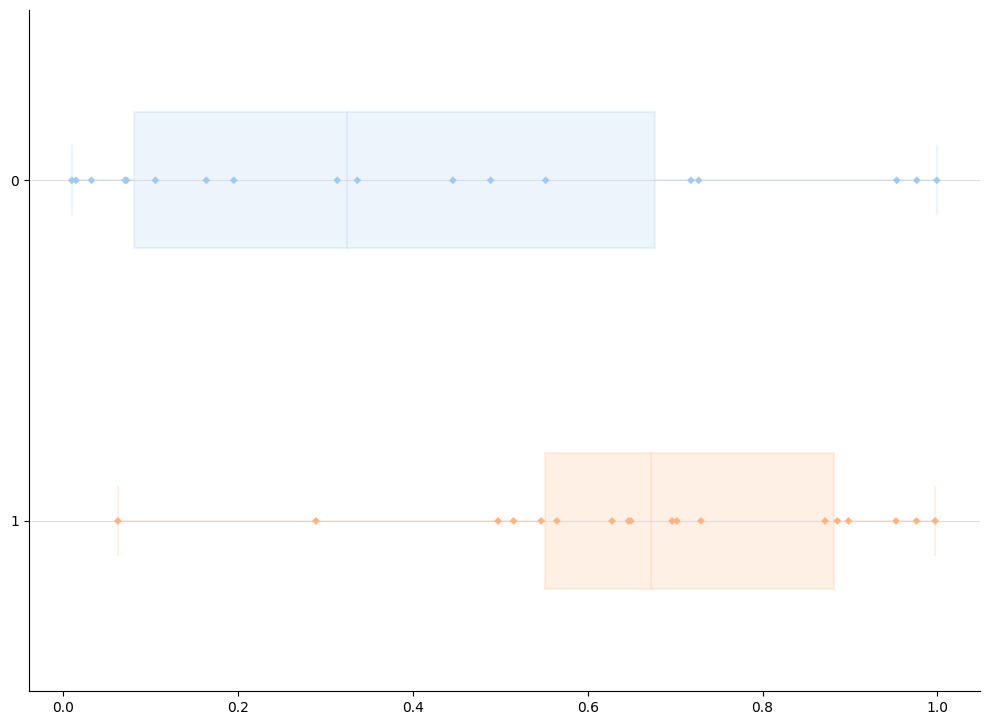

In [5]:
import matplotlib.patches as pltp
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
palette = ["#4D4F53", "#C41E3A"]
sns.boxplot(data = [all_probs[y == 0],all_probs[y == 1]],
            ax=ax,
            showfliers=False,
            palette="pastel",
            boxprops=dict(alpha=.2),
            whiskerprops=dict(alpha=.2),
            width=.4,
            orient="h",
            saturation=1
        )
sns.stripplot(data=[all_probs[y == 0],all_probs[y == 1]],
            ax=ax,
            palette="pastel",
            jitter = False,
            alpha=1,
            size=4,
            marker="D",orient="h"
        )
box_patches = [patch for patch in ax.patches if type(patch) == pltp.PathPatch]

num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches

for i, patch in enumerate(box_patches):
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor(col)

    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

ax.grid(which='major', color='#DDDDDD', linewidth=0.8, axis="y")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)



fig.tight_layout()
fig.subplots_adjust(top=0.9)
ax.set_ylabel('')

plt.show()

### Step 3: We get the final model

We fit the model on all of the data.

In [6]:
Xstd = pd.DataFrame(data=preprocessing.fit_transform(dataV3),
                          index=dataV3.index,
                          columns=preprocessing.get_feature_names_out()
                         )
model.fit(Xstd.to_numpy(), y)


LogisticRegression(C=2, class_weight='balanced', max_iter=1000000, penalty='l1',
                   solver='saga')

Then we look at which features get a non-zero coefficient, to get a similar understanding of which features were selected by the model.


In [7]:
for i in Xstd.columns[np.where(model.coef_[0] != 0)]:
    print(i)

Baso_IkB_Unstim
MDSC_MAPKAPK2_Unstim
pDC_S6_Unstim
CD4Tnaive_STAT3_Unstim
Th1mem_STAT5_Unstim
Th1mem_S6_Unstim
Th1mem_ERK_Unstim
Th1naive_STAT3_Unstim
Th1naive_ERK_Unstim
Th2_pSTAT6_Unstim
Treg_STAT5_Unstim
Tregmem_STAT5_Unstim
Tregnaive_STAT5_Unstim
Tregnaive_MAPKAPK2_Unstim
CD8Trm_MAPKAPK2_Unstim
Baso +++_IkB_Unstim
intMC_Frequency_Unstim
CD56dimCD16pos-NK_Frequency_Unstim
CD4Tcm_Frequency_Unstim
CD4Tnaive_Frequency_Unstim
CD4Trm_Frequency_Unstim
Tregmem_Frequency_Unstim
CD8Tem_Frequency_Unstim
Granulocytes_Frequency_Unstim


In [8]:
pd.DataFrame(data=all_probs,index=dataV3.index,columns=["LOO CV predictions"]).to_csv("./ResultsFinal/V3/FinalLASSO_CV_predictions.csv")

Boxplots for these features are further down.

### Part 2: Stability Selection

With a base estimator a Lasso model, we look at what features it selects:

In [9]:
ss =Stabl(
    base_estimator=clone(model),
    lambda_name="C",
    lambda_grid=np.linspace(0.01, 3, 50),
    artificial_type=None,
    sample_fraction=0.5,
    replace= True,
    hard_threshold=0.3,
    n_bootstraps=2000,
    random_state=42
)

ss.fit(Xstd,y)


Stabl(artificial_type=None,
      base_estimator=LogisticRegression(C=2, class_weight='balanced',
                                        max_iter=1000000, penalty='l1',
                                        solver='saga'),
      hard_threshold=0.7,
      lambda_grid=array([0.01      , 0.07102041, 0.13204082, 0.19306122, 0.25408163,
       0.31510204, 0.37612245, 0.43714286, 0.49816327, 0.55918367,
       0.62020408, 0.68122449, 0.7422449 , 0.80326531, 0.86428571,
       0.92530612, 0.9863265...
       1.23040816, 1.29142857, 1.35244898, 1.41346939, 1.4744898 ,
       1.5355102 , 1.59653061, 1.65755102, 1.71857143, 1.77959184,
       1.84061224, 1.90163265, 1.96265306, 2.02367347, 2.08469388,
       2.14571429, 2.20673469, 2.2677551 , 2.32877551, 2.38979592,
       2.45081633, 2.51183673, 2.57285714, 2.63387755, 2.69489796,
       2.75591837, 2.81693878, 2.87795918, 2.93897959, 3.        ]),
      n_bootstraps=2000, random_state=42, replace=True)

The stability path generated:

(<Figure size 400x800 with 1 Axes>,
 <Axes: xlabel='$\\lambda$', ylabel='Frequency of selection'>)

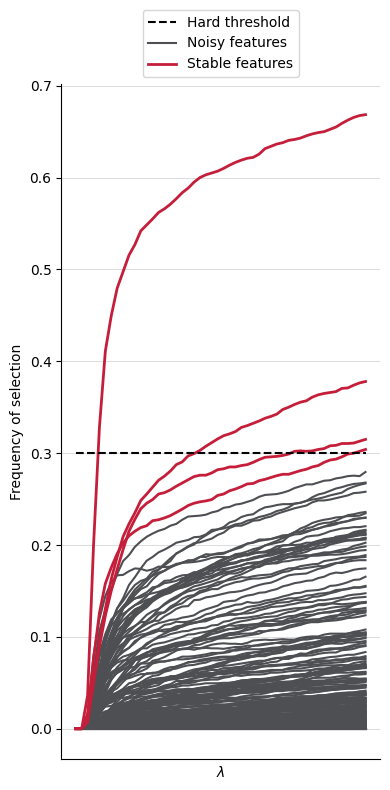

In [14]:
plot_stabl_path(ss)

The features selected:

In [15]:
ss.get_feature_names_out()

array(['Th1mem_S6_Unstim', 'Tregnaive_MAPKAPK2_Unstim',
       'intMC_Frequency_Unstim', 'CD8Tem_Frequency_Unstim'], dtype=object)

In [17]:
save_stabl_results(ss,"./ResultsFinal/V3/",dataV3,y)

c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


Here are the boxplots for the selected features - its long and you need to scroll!

c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\site-packages\stabl\visualization.py:260: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
c:\Users\Max\AppData\Local\Programs\Python\Python311\Lib\sit

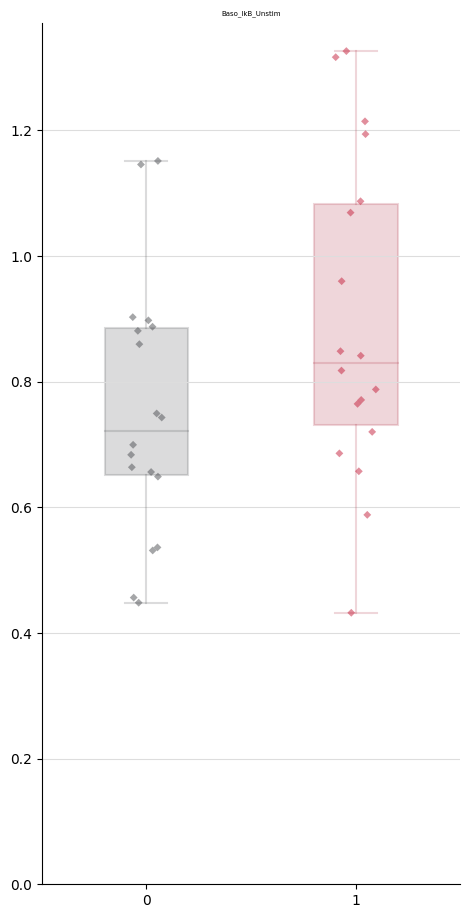

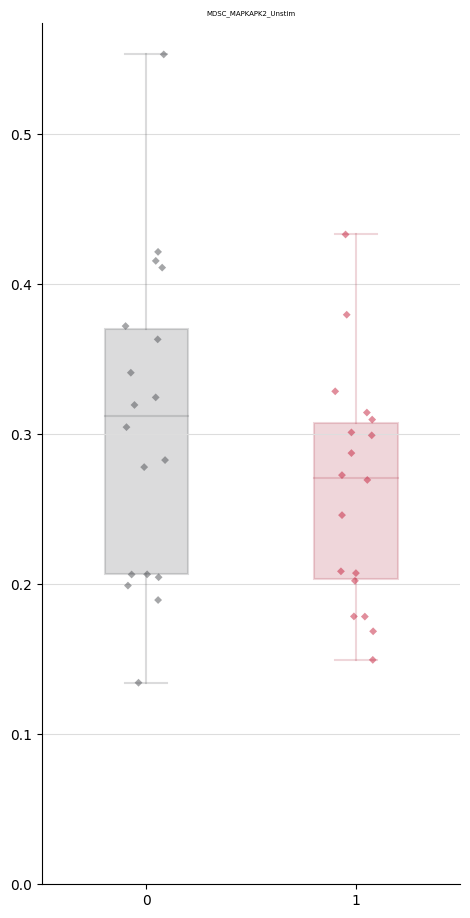

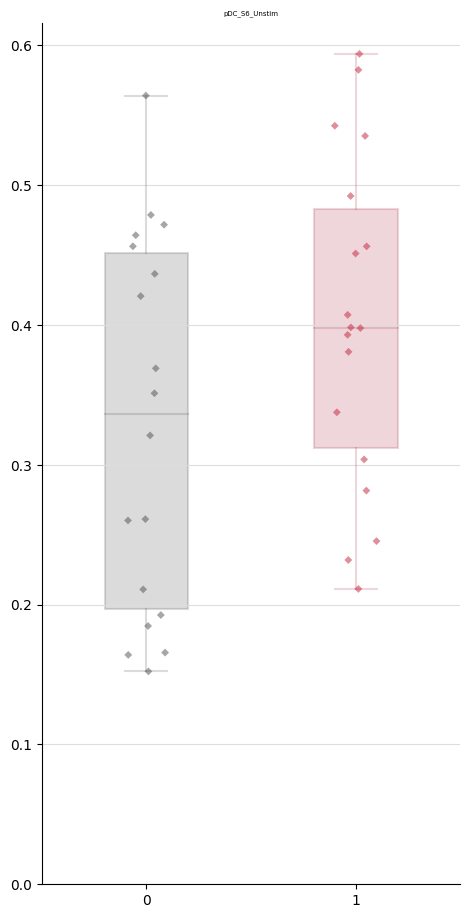

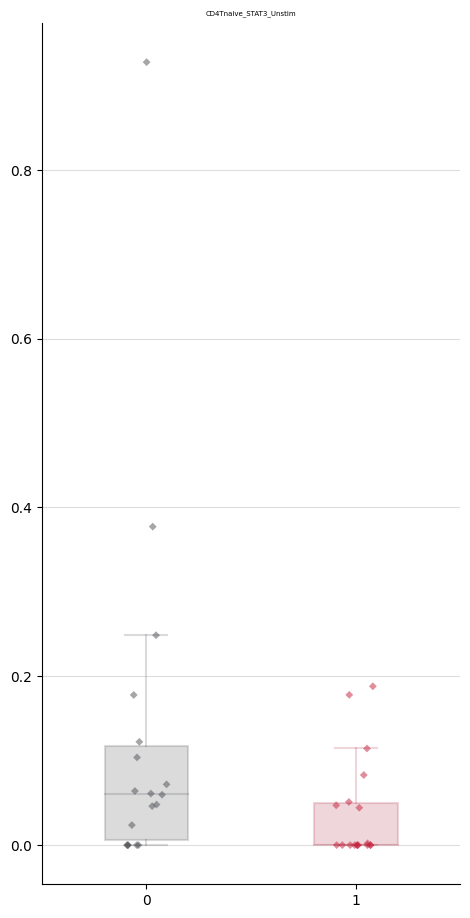

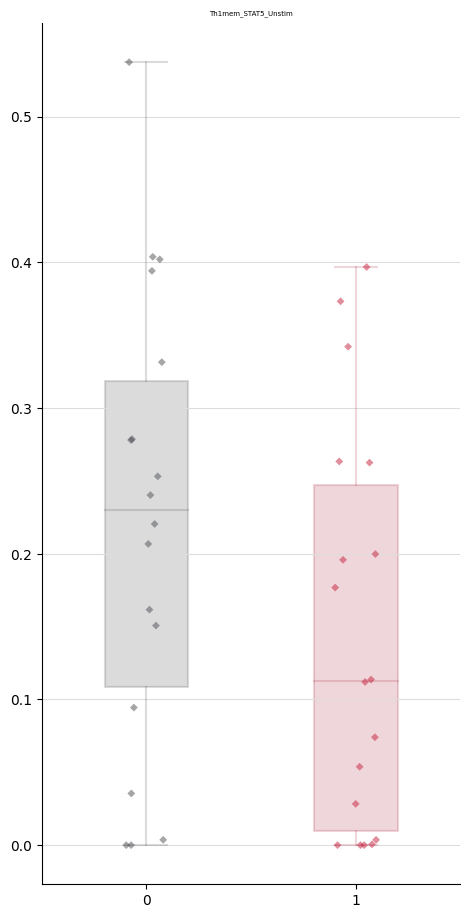

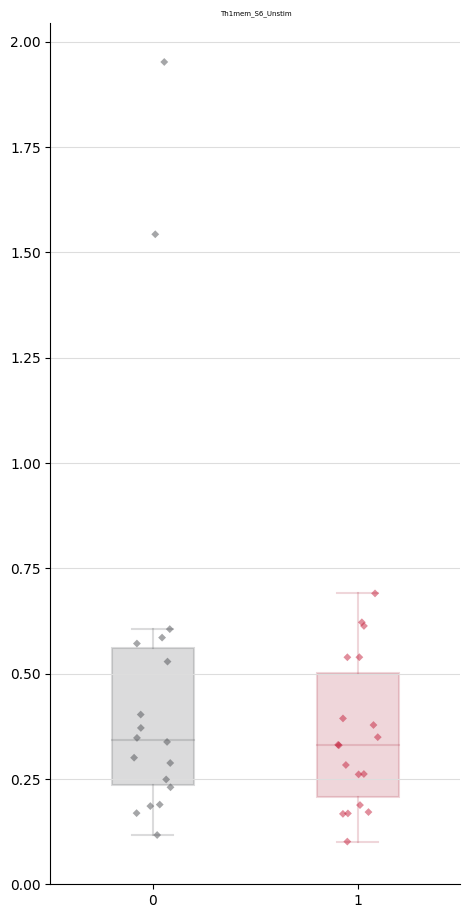

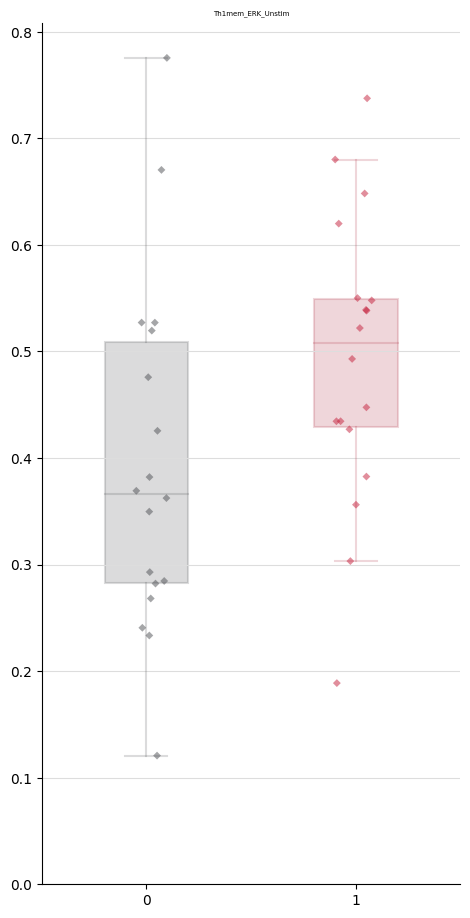

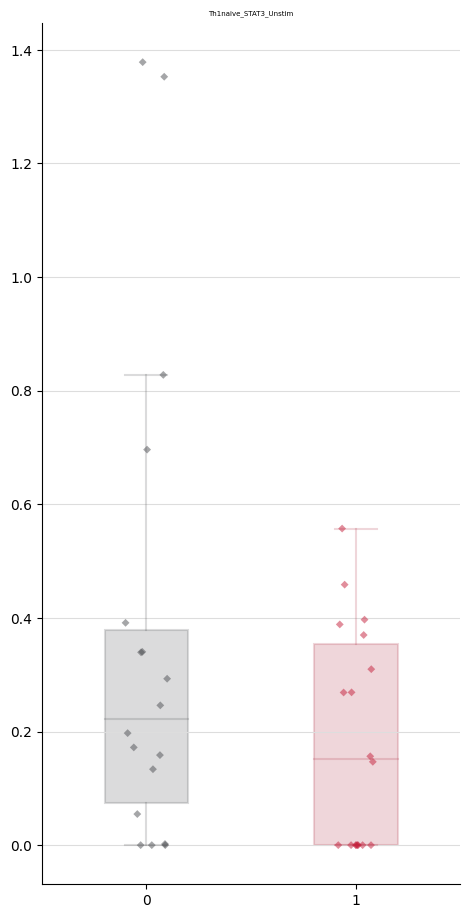

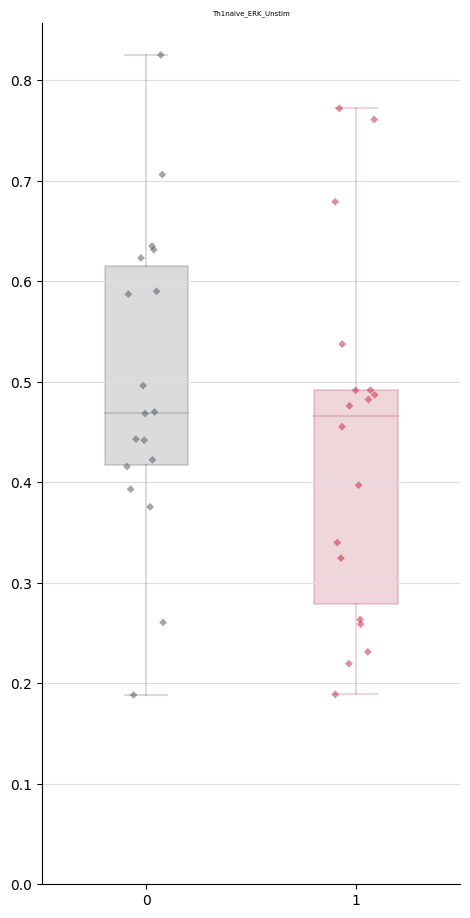

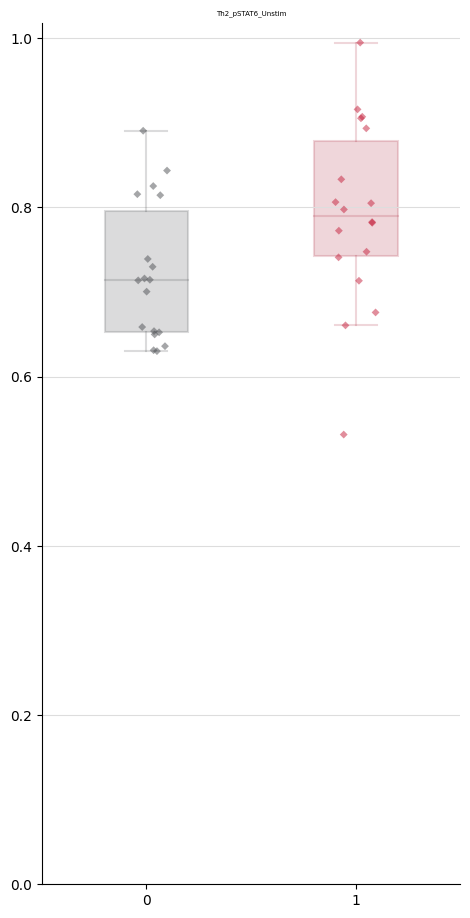

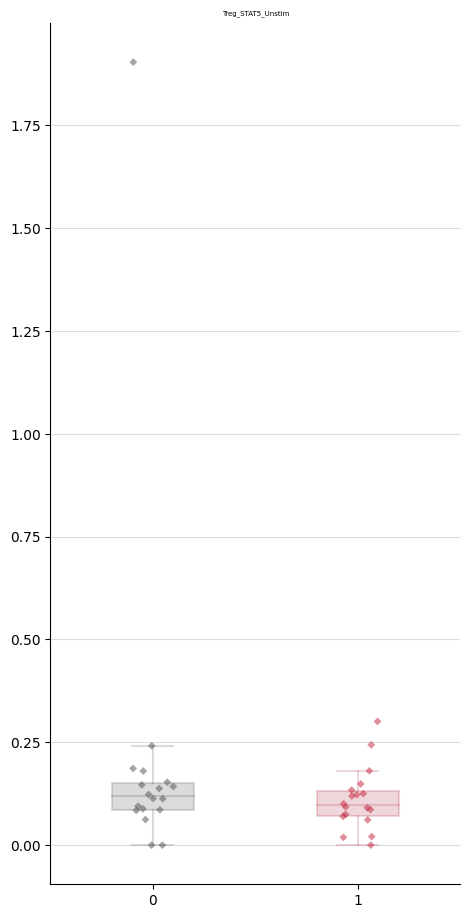

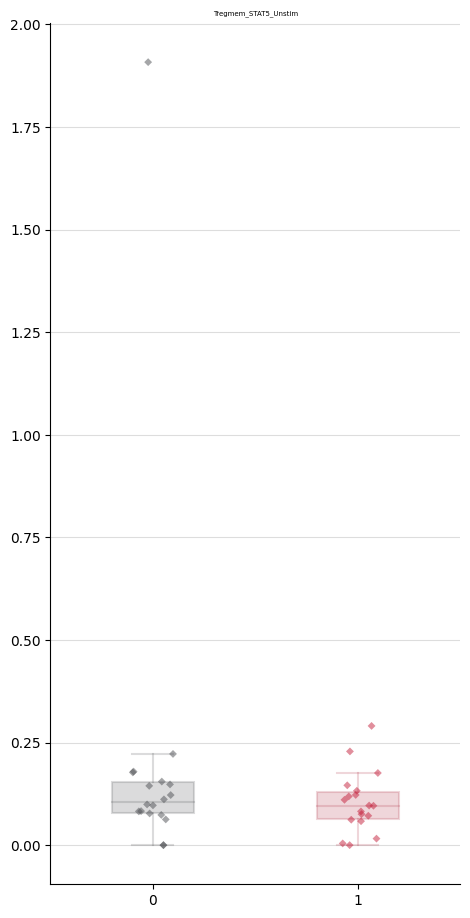

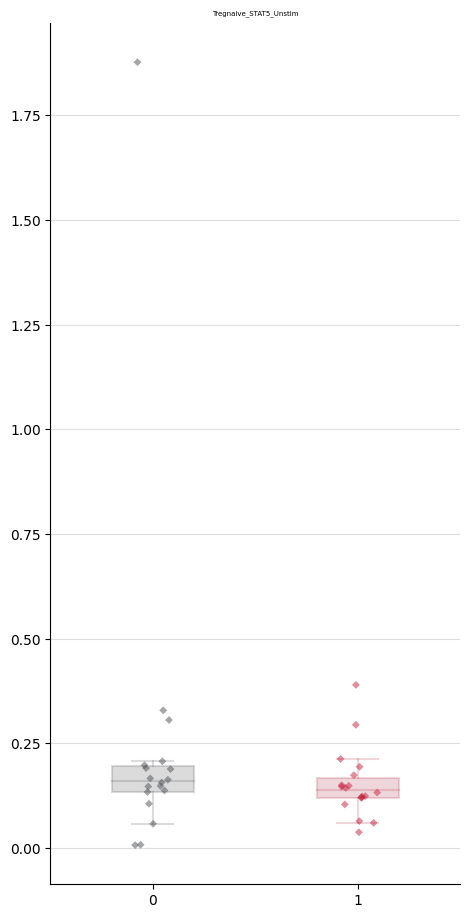

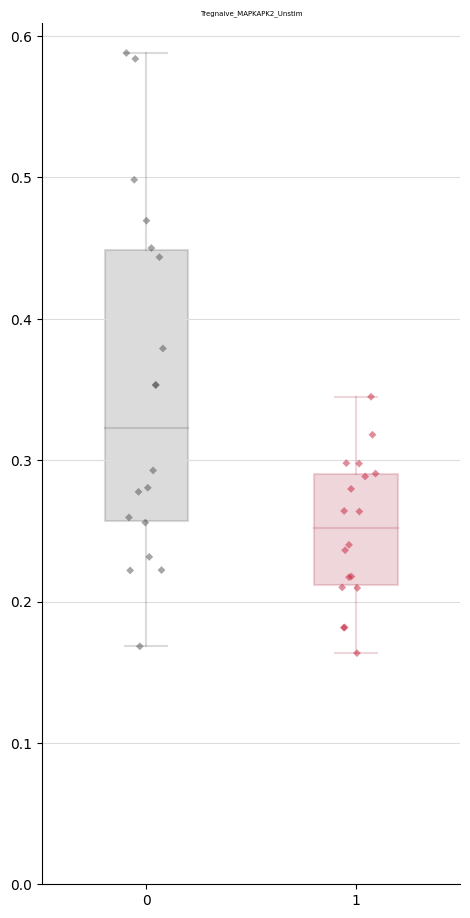

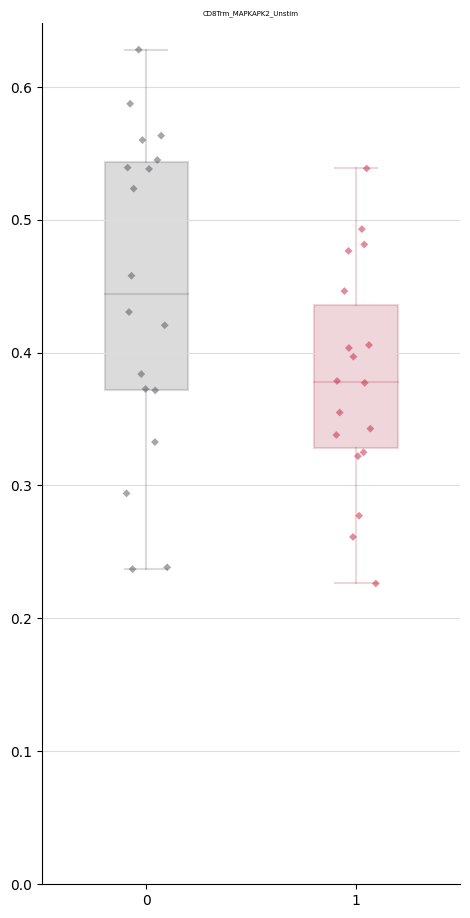

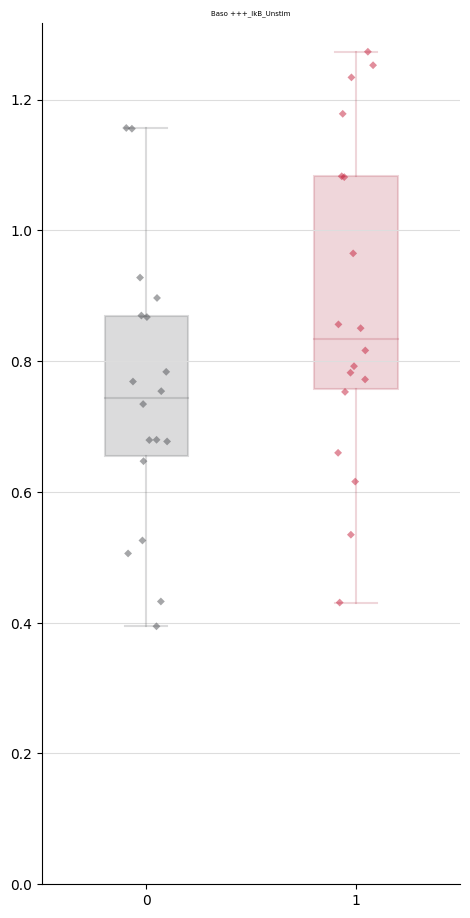

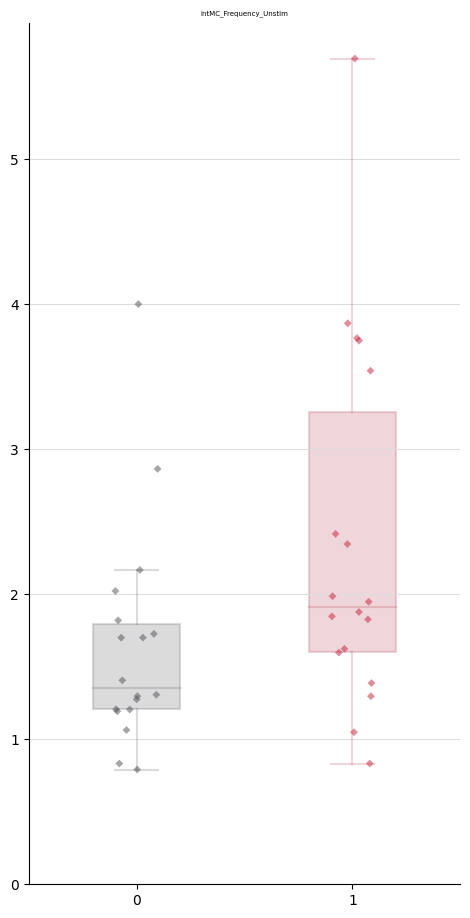

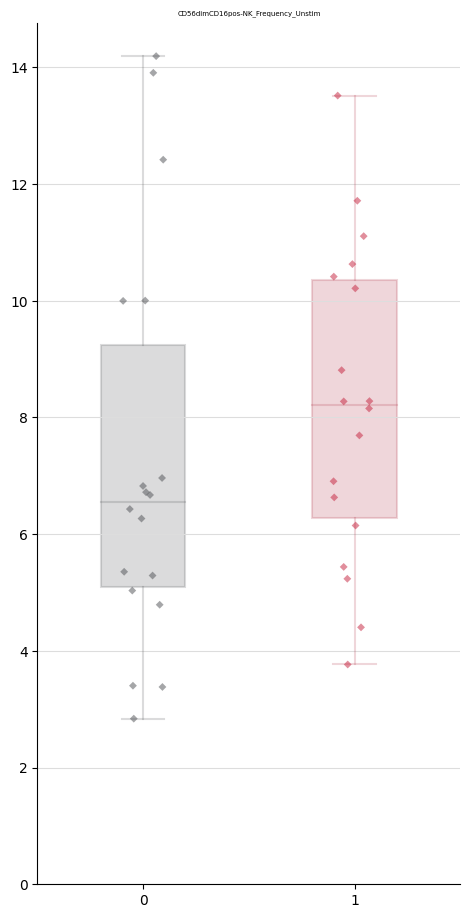

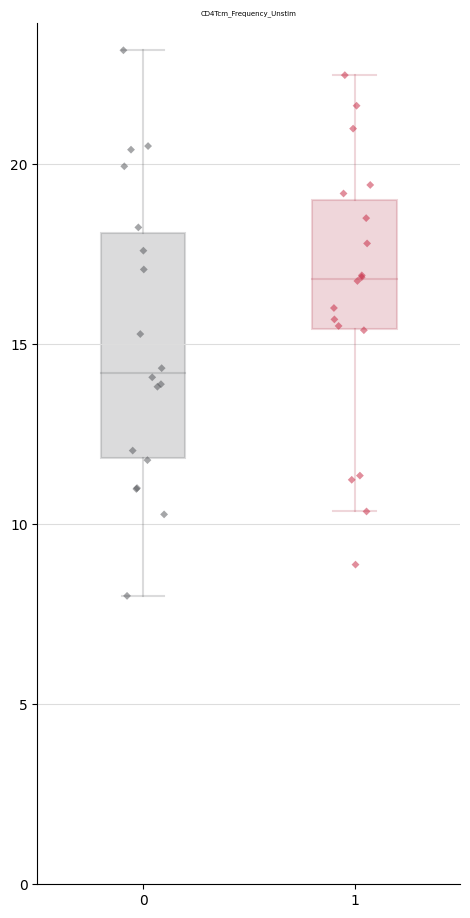

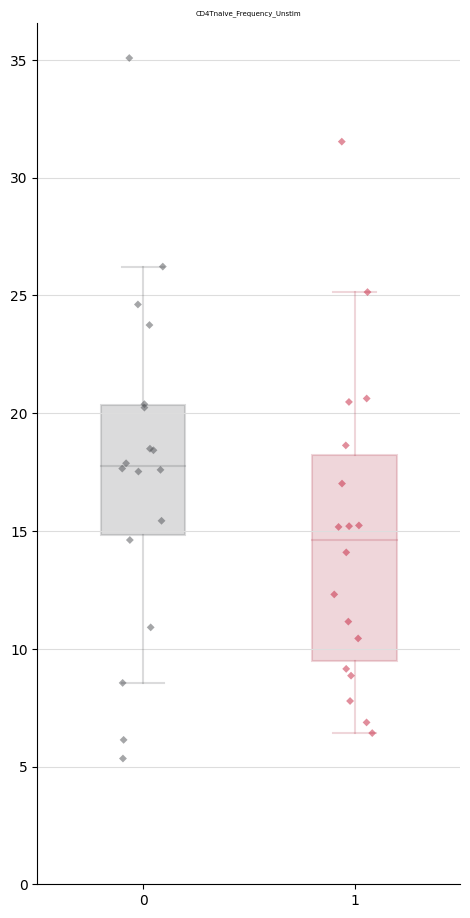

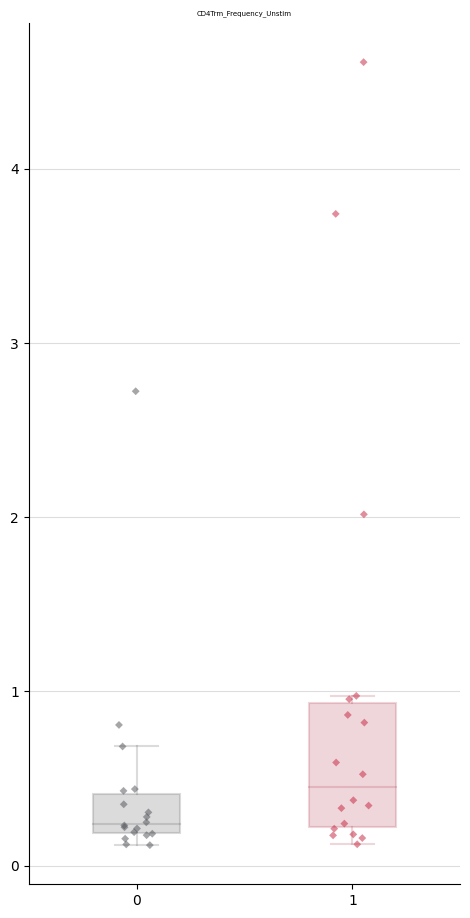

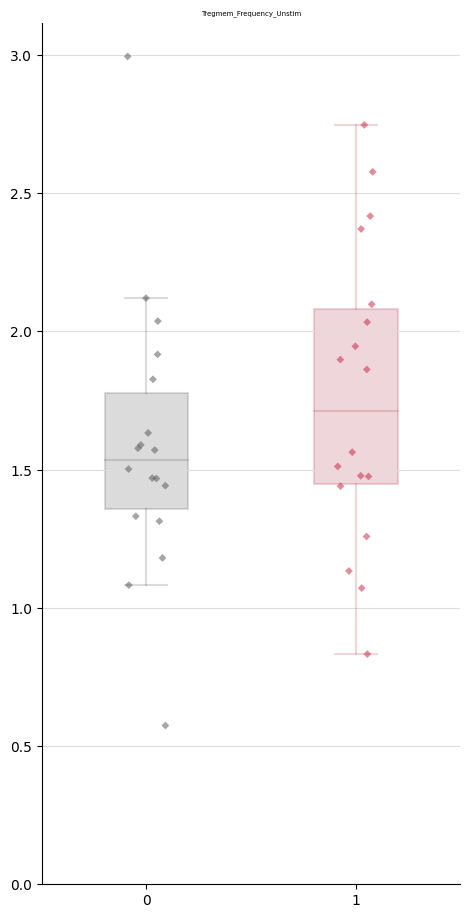

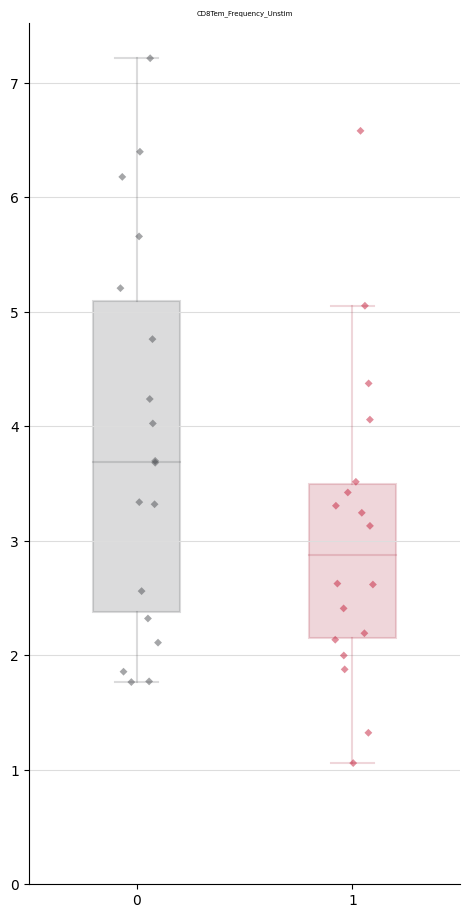

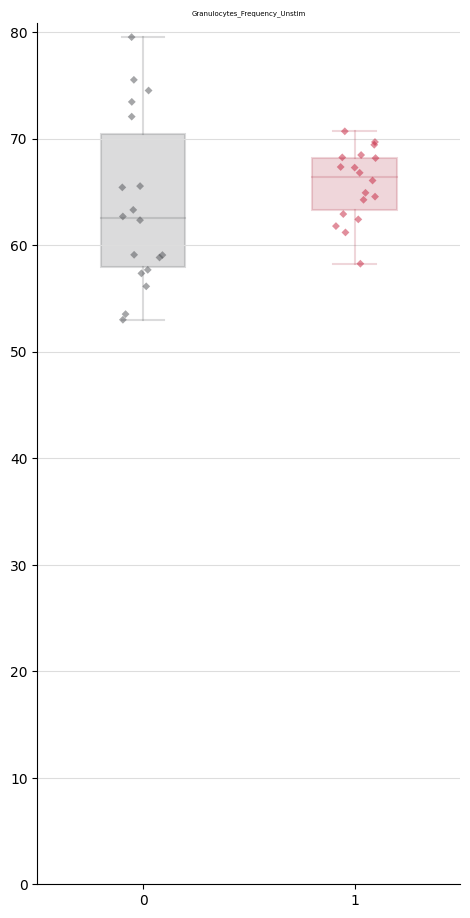

In [12]:
boxplot_features(Xstd.columns[np.where(model.coef_[0] != 0)], dataV3,y)